# Data Processing

In [1]:
#!/usr/bin/env python3
import time
from multiprocessing import cpu_count
from typing import Union, NamedTuple

from torch.utils import data
from torch import Tensor
from typing import Tuple
import torch
import torch.backends.cudnn
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import torchvision.datasets
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.utils.data import Dataset

import argparse
from pathlib import Path

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True


def crop_to_region(coords: Tuple[int], img: Tensor, crop_size: int=42) -> Tensor:
    """ 
    Given coordinates in the form Tuple[int](y, x), return a cropped
    sample of the input imaged centred at (y, x), matching the input size.
    Args:
        coords (Tuple[int]): The input coordinates (y, x) where the crop will be
        centred.
        img (Tensor): The input image, either 3x400x400, 3x250x250, 3x150x150
        crop_size (int, optional): The size of the returned crop. Defaults to 42.

    Returns:
        Tensor: The image cropped with central coordinates at (y, x) of size 
        (3 x size x size) # is size here referring to 42?
    """
    _, H, W = img.shape
    y, x = coords
    y_min, x_min = max(0, y-crop_size//2), max(0, x-crop_size//2)
    y_max, x_max = min(H, y+crop_size//2), min(W, x+crop_size//2)
    region = img[:, y_min:y_max, x_min:x_max]
    if region.shape[1] < crop_size:
        to_pad = crop_size - region.shape[1]
        padding = (0, 0, to_pad, 0) if (y-crop_size//2) < 0 else (0, 0, 0, to_pad)
        region = F.pad(region, padding, mode='replicate')

    if region.shape[2] < crop_size:
        to_pad = crop_size - region.shape[2]
        padding = (to_pad, 0, 0, 0) if (x-crop_size//2) < 0 else (0, to_pad, 0, 0)
        region = F.pad(region, padding, mode='replicate')
    return region

class MIT(data.Dataset):
    def __init__(self, dataset_path: str):
        """
        Given the dataset path, create the MIT dataset. Creates the
        variable self.dataset which is a list of dictionaries with three keys:
            1) X: For train the crop of image. This is of shape [3, 3, 42, 42]. The 
                first dim represents the crop across each different scale
                (400x400, 250x250, 150x150), the second dim is the colour
                channels C, followed by H and W (42x42). For inference, this is 
                the full size image of shape [3, H, W].
            2) y: The label for the crop. 1 = a fixation point, 0 = a
                non-fixation point. -1 = Unlabelled i.e. val and test
            3) file: The file name the crops were extracted from.
            
        If the dataset belongs to val or test, there are 4 additional keys:
            1) X_400: The image resized to 400x400
            2) X_250: The image resized to 250x250
            3) X_150: The image resized to 150x150
            4) spatial_coords: The centre coordinates of all 50x50 (2500) crops
            
        These additional keys help to load the different scales within the
        dataloader itself in a timely manner. Precomputing all crops requires too
        much storage for the lab machines, and resizing/cropping on the fly
        slows down the dataloader, so this is a happy balance.
        Args:
            dataset_path (str): Path to train/val/test.pth.tar
        """
        self.dataset = torch.load(dataset_path, weights_only=True)
        self.mode = 'train' if 'train' in dataset_path else 'inference'
        self.num_crops = 2500 if self.mode == 'inference' else 1

    def __getitem__(self, index) -> Tuple[Tensor, int]:
        """
        Given the index from the DataLoader, return the image crop(s) and label
        Args:
            index (int): the dataset index provided by the PyTorch DataLoader.
        Returns:
            Tuple[Tensor, int]: A two-element tuple consisting of: 
                1) img (Tensor): The image crop of shape [3, 3, 42, 42]. The 
                first dim represents the crop across each different scale
                (400x400, 250x250, 150x150), the second dim is the colour
                channels C, followed by H and W (42x42).
                2) label (int): The label for this crop. 1 = a fixation point, 
                0 = a non-fixation point. -1 = Unlabelled i.e. val and test.
        """
        sample_index = index // self.num_crops
        # print(sample_index)
        
        img = self.dataset[sample_index]['X']
        
        # Inference crops are not precomputed due to file size, do here instead
        if self.mode == 'inference': 
            _, H, W = img.shape
            crop_index = index % self.num_crops
            crop_y, crop_x = self.dataset[sample_index]['spatial_coords'][crop_index]
            scales = []
            for size in ['X_400', 'X_250', 'X_150']:
                scaled_img = self.dataset[sample_index][size]
                y_ratio, x_ratio = scaled_img.shape[1] / H, scaled_img.shape[2] / W
                
                # Need to rescale the crops central coordinate.
                scaled_coords = (int(y_ratio * crop_y), int(x_ratio * crop_x))
                crops = crop_to_region(scaled_coords, scaled_img)
                scales.append(crops)
            img = torch.stack(scales, axis=1)
            
        label = self.dataset[sample_index]['y']

        return img, label

    def __len__(self):
        """
        Returns the length of the dataset (length of the list of dictionaries * number
        of crops). 
        __len()__ always needs to be defined so that the DataLoader
            can create the batches
        Returns:
            len(self.dataset) (int): the length of the list of dictionaries * number of
            crops.
        """
        return len(self.dataset) * self.num_crops


trainingdata = MIT("data/train_data.pth.tar")
valdata = MIT("data/val_data.pth.tar")
testingdata = MIT("data/test_data.pth.tar")


class NormalisedDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# each element in self.dataset dictionary which has three components so just get X and y component (so X component 3x3x42x42 and y is label) -> inputs to the CNN


# print(trainingdata.dataset[0]['y'])
# print(trainingdata.dataset[0]['X'])


2024-11-23 17:00:54.699050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 17:00:54.706187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 17:00:54.714888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 17:00:54.717519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 17:00:54.723805: I tensorflow/core/platform/cpu_feature_guar

# Data Augmentation

In [2]:
import numpy as np
import statistics

training_data_augmented = trainingdata.dataset * 2
for i in range(len(trainingdata.dataset), len(training_data_augmented)):
    training_data_augmented[i]['X'] = torch.flip(training_data_augmented[i]['X'], dims=[3])
    
print('done')

red_channel = ([sample['X'][:, 0, :, :] for sample in training_data_augmented])
blue_channel = ([sample['X'][:, 1, :, :] for sample in training_data_augmented])
green_channel = ([sample['X'][:, 2, :, :] for sample in training_data_augmented])

normalised_training_data = training_data_augmented

# red channel is a list of 3x42x42 i.e each resolution 42x42 image only the red channel, likewise with the blue and green channel
# so want the mean of the red channels, blue and green channel

def channel_mean(x):
    return (torch.stack(x).mean().item())

def channel_std(x):
    return (torch.stack(x).std().item())

# def channel_mean(x):
#     channel_sum = 0 # sum is 0 to begin with
#     for i in range(0, len(x)): # go through each item in the list
#         item = x[i] # extract 3x42x42 list
#         for j in range(0, 3): # find the sum of each element of the 3x42x42 list and increment to the running sum
#             for k in range(0, 42):
#                 for l in range(0,42):
#                     channel_sum += item[j][k][l].item()
                    
#     return (channel_sum / (len(x)*3*42*42)) # mean of x i.e. total of all values / number of values 

red_mean = channel_mean(red_channel)
blue_mean = channel_mean(blue_channel)
green_mean = channel_mean(green_channel)

red_std = channel_std(red_channel)
blue_std = channel_std(blue_channel)
green_std = channel_std(green_channel)

print(red_mean, blue_mean, green_mean, red_std, blue_std, green_std)

for i in range(0, len(normalised_training_data)): # goes through the current list
    training_data_X = normalised_training_data[i]['X'] # gets the 3x3x42x42 X
    training_data_X[:,0,:,:] = (training_data_X[:,0,:,:] - red_mean) / red_std # gets red channel values and normalises them
    training_data_X[:, 1, :,:] = (training_data_X[:,1,:,:] - blue_mean) / blue_std
    training_data_X[:, 2, :,:] = (training_data_X[:,2,:,:] - green_mean) / green_std
    
    normalised_training_data[i]['X'] = training_data_X
    #print('in loop')

final_data = trainingdata
final_data.dataset = normalised_training_data

print('hello')

done
0.01992413029074669 -0.003527479013428092 -0.011873003095388412 0.9579979777336121 0.948402464389801 0.9503791928291321
hello


In [3]:
k = 0

In [4]:
k += 1

In [ ]:
# visualise training data for sanity check

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

X = trainingdata.dataset[k]['X'][1].permute(1, 2, 0).numpy() * 255
y = trainingdata.dataset[k]['y']

print(y)

axes[0].imshow(X)
axes[0].set_title('X')
axes[0].axis('off')  # Turn off axis ticks

# axes[0].imshow(y)
# axes[0].set_title('y')
# axes[0].axis('off')  # Turn off axis ticks
plt.show()

# Format Files and Generate Ground Truth

In [3]:
# this code generates the ground truth dictionary for inference datasets indexed by file name (formatted so they end with _fixMap.jpg)
# ensure the predictions dictionary matches this format for file name

def format_file_name_fixMap_jpg(filename):
    return f"{filename[:-5]}_fixMap.jpg"

def get_filenames_fixMap_jpg(dataset: Dataset):
    filenames = [format_file_name_fixMap_jpg(sample['file']) for sample in dataset]

    return filenames

def get_ground_truth_dict(dataset: Dataset):

    filenames = get_filenames_fixMap_jpg(dataset)

    ground_truth_dict = {}
    transform = transforms.ToTensor()

    for filename in filenames:
        ground_truth_dict[filename] = transform(Image.open(f"data/ALLFIXATIONMAPS/ALLFIXATIONMAPS/{filename}")).squeeze() * 255
    
    return ground_truth_dict

# to show usage
# print(list(get_ground_truth_dict(get_filenames_fixMap_jpg(valdata.dataset)).values())[7].shape)

val_ground_truth_dict = get_ground_truth_dict(valdata.dataset)
test_ground_truth_dict = get_ground_truth_dict(testingdata.dataset)

print(list(get_ground_truth_dict(valdata.dataset).values())[0].shape)
print(valdata.dataset[0]['X'].shape)

torch.Size([768, 1024])
torch.Size([3, 768, 1024])


# Define ROC-AUC Evaluation

In [4]:
# metrics code


import numpy as np
from scipy.integrate import simpson


def roc_auc(pred, target, n_points=20, include_prior=False):
        """
        Calculates the Reciever-Operating-Characteristic (ROC) area under
        the curve (AUC) by numerical integration.
        """

        target = np.array(target)/255
                
        # generated = pred
        # changed above comment line to below one as above was throwing error
        generated = np.array(pred)
        # min max normalisation
        generated = (generated - generated.min())/(generated.max() - generated.min())

        def roc(p=0.1):
            x = generated.reshape(-1) > p
            t = target.reshape(-1) > p

            return np.sum(x==t)/len(t)

        calculate_roc = np.vectorize(roc)

        x = np.linspace(0, 1, n_points)
        auc = simpson(calculate_roc(x))/n_points

        return auc

def calculate_auc(preds, targets):
	"""
	inputs -- 2 dictionary with prediction and target images. The 2 dictionaries have the  same number of keys, where each key identifies a unique image. 
	The predictions have the predicted fixation maps while the targets have the ground truth fixation maps which are available from "https://people.csail.mit.edu/tjudd/WherePeopleLook/" 
	"""
	assert preds.keys() == targets.keys()
	mean_auc = 0
	for key in preds.keys():
		mean_auc += roc_auc(preds[key], targets[key])
	mean_auc /= len(preds.keys())
	return mean_auc


# Model checkpointing

In [88]:
val_model_path = "./model/val/model.pth"
val_auc_path = "./model/val/auc_score"
test_model_path = "./model/test/model.pth"
test_auc_path = "./model/test/auc_score"

all_models_path = "./data/models/"

def checkpoint_model(model, auc, is_test):
    model_path = ""
    auc_path = ""

    if is_test:
        model_path = test_model_path
        auc_path = test_auc_path

        if auc > 0.65:
            torch.save(model, f"{all_models_path}model_test_{str(auc)[:5]}.pth")
    else:
        model_path = val_model_path
        auc_path = val_auc_path

        if auc > 0.65:
            torch.save(model, f"{all_models_path}model_val_{str(auc)[:5]}.pth")

    # scoreboard type checkpointing
    path = Path(auc_path)  # Path to the file you want to check

    if path.exists():
        with open(auc_path, 'r+', encoding='utf-8') as file:
            
            old_auc = float(file.read().strip())

            if auc > old_auc:
                torch.save(model, model_path)
                
                file.truncate(0)
                file.seek(0)
                file.write(str(auc))
    else:
        torch.save(model, model_path)
    
        with open(auc_path, 'w', encoding='utf-8') as file:
            file.write(str(auc))

# Initialise and Train Mr-CNN

### To see logs:
module load anaconda \
pip install tensorboard \
python3 -m tensorboard.main --logdir=./logs \

In [ ]:
from torchviz import make_dot

parser = argparse.ArgumentParser(
    description="Train a simple CNN on CIFAR-10",
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
)
default_dataset_dir = Path.home() / ".cache" / "torch" / "datasets"
parser.add_argument("--dataset-root", default=default_dataset_dir)
parser.add_argument("--log-dir", default=Path("logs"), type=Path)
parser.add_argument("--learning-rate", default=2e-4, type=float, help="Learning rate")
parser.add_argument(
    "--batch-size",
    default=256,
    type=int,
    help="Number of images within each mini-batch",
)
parser.add_argument(
    "--epochs",
    default=50,
    type=int,
    help="Number of epochs (passes through the entire dataset) to train for",
)
parser.add_argument(
    "--val-frequency",
    default=5,
    type=int,
    help="How frequently to test the model on the validation set in number of epochs",
)
parser.add_argument(
    "--log-frequency",
    default=10,
    type=int,
    help="How frequently to save logs to tensorboard in number of steps",
)
parser.add_argument(
    "--print-frequency",
    default=10,
    type=int,
    help="How frequently to print progress to the command line in number of steps",
)
parser.add_argument(
    "-j",
    "--worker-count",
    default=0, #cpu_count(), #note make this 0 if not using lab machine
    type=int,
    help="Number of worker processes used to load data.",
)
parser.add_argument("--sgd-momentum", default=0.9, type=float)
parser.add_argument("--data-aug-hflip", action="store_true")
parser.add_argument("--dropout", default=0.5, type=float)
parser.add_argument("--max_norm", default=0.1, type=float)



class ImageShape(NamedTuple):
    height: int
    width: int
    channels: int


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

# to save and manually evaluate trained model
trained_model = 0
test_auc_score = 0

def main(args):

    for i in range(20):

        train_loader = torch.utils.data.DataLoader(
            final_data,
            shuffle=True,
            batch_size=args.batch_size,
            pin_memory=True,
            num_workers=args.worker_count,
        )
        
        print(args)
        
        args.dataset_root.mkdir(parents=True, exist_ok=True)
        
        test_dataset = testingdata.dataset
        
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            shuffle=False,
            batch_size=args.batch_size,
            num_workers=args.worker_count,
            pin_memory=True,
        )

        model = CNN(height=42, width=42, channels=3, class_count=2, dropout=args.dropout)

        # for torchviz visualisation of architecture
        dummy_input = torch.randn(1, 3, 3, 42, 42)

        output = model(dummy_input)

        graph = make_dot(output, params=dict(model.named_parameters()))

        # Save or render the graph
        graph.render("cnn_graph_merged", format="png")  # Save as PNG

        # define criterion as Binary Cross Entropy Loss - it does sigmoid as built in
        criterion = nn.BCEWithLogitsLoss()

        # define optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.sgd_momentum, weight_decay=2e-4)

        log_dir = get_summary_writer_log_dir(args)
        print(f"Writing logs to {log_dir}")
        summary_writer = SummaryWriter(
                str(log_dir),
                flush_secs=5
        )
        trainer = Trainer(
            model, train_loader, test_loader, criterion, optimizer, summary_writer, DEVICE
        )

        print("About to train...")
        trainer.train(
            args.epochs,
            args.val_frequency,
            print_frequency=args.print_frequency,
            log_frequency=args.log_frequency,
        )
        print("Finished training.")
        summary_writer.close()

        print("\nTESTING MODEL")
        test_auc = test_model(model, testingdata, test_ground_truth_dict, DEVICE)
        print("AUC:", test_auc, "on test dataset\n")

        # save model locally in notebook for manual evaluation
        checkpoint_model(model, float(test_auc), True)



class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: Optimizer,
        summary_writer: SummaryWriter,
        device: torch.device,
    ):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.summary_writer = summary_writer
        self.step = 0


            
    def train(
        self,
        epochs: int,
        val_frequency: int,
        print_frequency: int = 20,
        log_frequency: int = 5,
        start_epoch: int = 0
    ):
        self.model.train()
        
        for epoch in range(start_epoch, epochs):

            self.model.train()
            
            data_load_start_time = time.time()

            epoch_accuracy = 0
            epoch_loss = 0

            for batch, labels in self.train_loader:
                
                batch = batch.to(self.device)
                labels = labels.to(self.device)
                data_load_end_time = time.time()

                # forward pass
                logits = self.model.forward(batch).squeeze()

                # compute loss using criterion
                loss = self.criterion(logits, labels.float())

                # backward pass
                loss.backward()

                # step optimizer and zero out gradient buffer
                self.optimizer.step()
                self.optimizer.zero_grad()


                
                with torch.no_grad():
                    preds = (logits > 0.5).float()
                    accuracy = compute_accuracy(labels, preds)

                data_load_time = data_load_end_time - data_load_start_time
                step_time = time.time() - data_load_end_time
                if ((self.step + 1) % log_frequency) == 0:
                    self.log_metrics(epoch, accuracy, loss, data_load_time, step_time)
                if ((self.step + 1) % print_frequency) == 0:
                    self.print_metrics(epoch, accuracy, loss, data_load_time, step_time)

                self.step += 1
                data_load_start_time = time.time()

                epoch_accuracy += accuracy
                epoch_loss += loss

            #update the momentum in the optimizer so that it linearly increases from 0.9 to 0.99
            update_momentum(self.model, self.optimizer, epoch, epochs, start_momentum=0.9, end_momentum=0.99)

            # apply weight constraints to limit the magnitude of all weights (should we apply per batch or per epoch?)
            apply_max_norm(self.model, 0.1)

            # log epoch accuracy and epoch loss
            epoch_accuracy /= self.train_loader.batch_size
            epoch_loss /= self.train_loader.batch_size
            self.summary_writer.add_scalar("epoch_accuracy", epoch_accuracy, self.step)
            self.summary_writer.add_scalar("epoch_loss", epoch_loss, self.step)

            self.summary_writer.add_scalar("epoch", epoch, self.step)
            if ((epoch + 1) % val_frequency) == 0:
                val_auc = self.validate()
                checkpoint_model(self.model, float(val_auc), False)
                # log val auc
                self.summary_writer.add_scalar("val_auc", val_auc, self.step)
                # self.validate() will put the model in validation mode,
                # so we have to switch back to train mode afterwards
                self.model.train()


    
    def print_metrics(self, epoch, accuracy, loss, data_load_time, step_time):
        epoch_step = self.step % len(self.train_loader)
        print(
                f"epoch: [{epoch}], "
                f"step: [{epoch_step}/{len(self.train_loader)}], "
                f"batch loss: {loss:.5f}, "
                f"batch accuracy: {accuracy * 100:2.2f}, "
                f"data load time: "
                f"{data_load_time:.5f}, "
                f"step time: {step_time:.5f}"
        )

    def log_metrics(self, epoch, accuracy, loss, data_load_time, step_time):
        self.summary_writer.add_scalar("epoch", epoch, self.step)
        self.summary_writer.add_scalars(
                "accuracy",
                {"train": accuracy},
                self.step
        )
        self.summary_writer.add_scalars(
                "loss",
                {"train": float(loss.item())},
                self.step
        )
        self.summary_writer.add_scalar(
                "time/data", data_load_time, self.step
        )
        self.summary_writer.add_scalar(
                "time/data", step_time, self.step
        )

    def validate(self):

        print("\nValidating model...")

        auc = test_model(self.model, valdata, val_ground_truth_dict, self.device)

        print("AUC:", auc, "on validation dataset\n")

        return auc

def update_momentum(self, optimizer, epoch, max_epochs, start_momentum=0.9, end_momentum=0.99):
    momentum = start_momentum + (end_momentum - start_momentum) * (epoch / max_epochs)
    for param_group in optimizer.param_groups:
        param_group['momentum'] = momentum

# Apply weight constraints
def apply_max_norm(model, max_norm):
    with torch.no_grad():
        for param in model.parameters():
            if param.requires_grad:
                param.clamp_(-max_norm, max_norm)

def test_model(model, dataMIT, ground_truth_dict, device):
    
    model.eval()

    dataset_size = len(dataMIT.dataset)

    batch_size = 50
    num_batches = int(2500 / batch_size)

    preds_dict = {}

    sigmoid = nn.Sigmoid()

    for i in range (dataset_size):

        # potential bug: getting height and width mixed up, so if results look bad, make sure to check this is right

        formatted_filename = format_file_name_fixMap_jpg(dataMIT.dataset[i]['file'])
        height = dataMIT.dataset[i]['X'].shape[1]
        width = dataMIT.dataset[i]['X'].shape[2]

        rescale_to_img = transforms.Resize((height, width))

        img_crops = torch.stack([dataMIT.__getitem__(i * 2500 + j)[0] for j in range(2500)])

        preds_rows = []

        for j in range(num_batches):
            
            batch = img_crops[j * batch_size:(j * batch_size) + batch_size,:,:,:,:]

            batch = batch.to(device)

            preds = sigmoid(model(batch).detach().cpu().reshape(1, 50))
            # preds = (preds > 0.5).float()
            preds_rows.append(preds)


        sal_map = torch.cat(preds_rows, 0)

        sal_map = rescale_to_img(sal_map.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)    # unsqueezing and squeezing done because transforms.Resize requires (., ., H, W) shape tensor
        sal_map = rescale_to_img(sal_map) * 255


        preds_dict[formatted_filename] = sal_map

    auc = calculate_auc(preds_dict, ground_truth_dict)

    return auc


def compute_accuracy(
    labels: Union[torch.Tensor, np.ndarray], preds: Union[torch.Tensor, np.ndarray]
) -> float:
    """
    Args:
        labels: ``(batch_size, class_count)`` tensor or array containing example labels
        preds: ``(batch_size, class_count)`` tensor or array containing model prediction
    """
    assert len(labels) == len(preds)
    return float((labels == preds).sum()) / len(labels)


def get_summary_writer_log_dir(args: argparse.Namespace) -> str:
    """Get a unique directory that hasn't been logged to before for use with a TB
    SummaryWriter.

    Args:
        args: CLI Arguments

    Returns:
        Subdirectory of log_dir with unique subdirectory name to prevent multiple runs
        from getting logged to the same TB log directory (which you can't easily
        untangle in TB).
    """
    tb_log_dir_prefix = (
    f"CNN_bn_"
    f"bs={args.batch_size}_"
    f"lr={args.learning_rate}_"
    f"momentum=0.9_" +
    ("hflip_" if args.data_aug_hflip else "") +
    f"run_"
)
    i = 0
    while i < 1000:
        tb_log_dir = args.log_dir / (tb_log_dir_prefix + str(i))
        if not tb_log_dir.exists():
            return str(tb_log_dir)
        i += 1
    return str(tb_log_dir)


if __name__ == "__main__":
    args, _ = parser.parse_known_args()
    main(args)


In [ ]:

# code for CBAM parts inspired (taken from and modified accordingly) by code at https://github.com/w6688j/CBAM/blob/master/model/resnet_cbam.py
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.fc1 = nn.Linear(in_planes, in_planes // ratio, bias=False)
        # self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.fc2 = nn.Linear(in_planes // ratio, in_planes, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # print("shapeee", x.shape)
        # import sys ; sys.exit(0)

        avg_out = self.avg_pool(x).squeeze().squeeze()
        avg_out = self.fc1(avg_out)
        avg_out = F.relu(avg_out)
        avg_out = self.fc2(avg_out)

        max_out = self.max_pool(x).squeeze().squeeze()
        max_out = self.fc1(max_out)
        max_out = F.relu(max_out)
        max_out = self.fc2(max_out)

        # avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        # max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))

        out = (avg_out + max_out).unsqueeze(2).unsqueeze(3)
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)




class CNN(nn.Module):
    def __init__(self, height: int, width: int, channels: int, class_count: int, dropout:float):
        super().__init__()
        self.input_shape = ImageShape(height=height, width=width, channels=channels)
        self.class_count = class_count

        self.dropout = nn.Dropout(p=dropout)
        self.dropout2d = nn.Dropout2d(p=dropout)

        # Define 1st Conv, Pool, and BatchNorm
    
        # Conv 1
        self.conv1 = nn.Conv2d(
            in_channels=self.input_shape.channels,
            out_channels=96,
            kernel_size=(7, 7),
            padding= (0,0), #(2, 2),
        )
        self.initialise_layer(self.conv1)
        
        # Pool 1
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # BatchNorm 1
        self.batchnorm1 = nn.BatchNorm2d(self.conv1.out_channels)

        # attention 1
        self.ca1 = ChannelAttention(96)
        self.sa1 = SpatialAttention()

        # Define 2nd Conv, Pool, and BatchNorm
        
        # Conv 2
        self.conv2 = nn.Conv2d(
            in_channels=96,
            out_channels=160,
            kernel_size=(3, 3),
            padding= (0,0) #(2, 2)
        )

        self.initialise_layer(self.conv2)
        
        # Pool 2
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # BatchNorm 2
        self.batchnorm2 = nn.BatchNorm2d(num_features=self.conv2.out_channels)

        # attention 2
        self.ca2 = ChannelAttention(160)
        self.sa2 = SpatialAttention()
        
        # Define 3rd Conv, Pool, and BatchNorm
        
        # Conv 3
        self.conv3 = nn.Conv2d(
            in_channels=160,
            out_channels=288,
            kernel_size=(3, 3),
            padding= (0,0) #(2, 2)
        )

        self.initialise_layer(self.conv3)
        
        # Pool 3
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # BatchNorm 3
        self.batchnorm3 = nn.BatchNorm2d(num_features=self.conv3.out_channels)

        # attention 3
        self.ca3 = ChannelAttention(288)
        self.sa3 = SpatialAttention()


        # Define FC 1

        self.fc1 = nn.Linear(2592, 512)
        self.initialise_layer(self.fc1)

        # BatchNorm layer after first FC layer
        # import pdb; pdb.set_trace()
        self.batchnorm4 = nn.BatchNorm1d(num_features=self.fc1.out_features)

        
        # Define FC 2

        # self.fc2 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(1536, 512)

        self.initialise_layer(self.fc2)

        # BatchNorm layer after second FC layer

        self.batchnorm5 = nn.BatchNorm1d(num_features=self.fc2.out_features)
        
        # Define FC 3

        self.fc3 = nn.Linear(512, 1)
        self.initialise_layer(self.fc3)

        # BatchNorm layer after third FC layer
        self.batchnorm6 = nn.BatchNorm1d(num_features=self.fc3.out_features)
    
    # FORWARD METHOD
    def forward(self, images: torch.Tensor) -> torch.Tensor:

        batch_size = images.shape[0]

        images = images.reshape(-1, 3, 42, 42)
        
        x = F.relu(self.conv1(images))
        x = self.pool1(x)
        # x = self.batchnorm1(x)

        x = self.ca1(x) * x
        x = self.sa1(x) * x

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # x = self.batchnorm2(x)


        x = self.ca2(x) * x
        x = self.sa2(x) * x

        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # x = self.dropout2d(x)
        # x = self.batchnorm3(x)

        # x = x.reshape(-1, 3, 42, 42)

        # print(x.shape)
        # print(x_ca.shape)

        # import sys ; sys.exit(0)

        x = self.ca3(x) * x
        x = self.sa3(x) * x


        # Flatten the output of the pooling layer so it is of shape (batch_size, 4096)
        x = torch.flatten(x, start_dim=1)

        # print(x.shape)
        
        # Pass x through the first fully connected layer
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = self.batchnorm4(x)


        x = x.reshape(batch_size, -1)


        # x = self.fc2(xCat)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)

        # x = self.batchnorm5(x)
        
        x = self.fc3(x)
        #x = self.batchnorm6(x)

        return x

    @staticmethod
    def initialise_layer(layer):
        if hasattr(layer, "bias"):
            nn.init.zeros_(layer.bias)
        if hasattr(layer, "weight"):
            nn.init.kaiming_normal_(layer.weight)

# Qualitative Analysis

In [93]:
# load model

model_file_path = all_models_path + "model_val_0.837.pth"

trained_model = torch.load(model_file_path)
trained_model.eval()

/tmp/ipykernel_1345419/1658102679.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load(model_file_path)


CNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2d): Dropout2d(p=0.5, inplace=False)
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ca1): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc1): Linear(in_features=96, out_features=6, bias=False)
    (fc2): Linear(in_features=6, out_features=96, bias=False)
    (sigmoid): Sigmoid()
  )
  (sa1): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (conv2): Conv2d(96, 160, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, t

In [94]:
def visualise_sal_map(sal_map):

    # Convert the tensor to a numpy array (matplotlib works well with numpy arrays)
    map_np = sal_map.numpy()

    # Plot the tensor as an image
    plt.imshow(map_np, cmap='gray', interpolation='nearest')
    # plt.colorbar()  # Optional: add a colorbar to visualize the range of values
    plt.title('Saliency Map')
    plt.axis('off')  # Turn off axis ticks
    plt.show()

def visualise_triple(pred_sal_map, gt_sal_map, img):
    pred_map_np = pred_sal_map.numpy()
    gt_map_np = gt_sal_map.numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the tensor as an image
    axes[0].imshow(pred_map_np, cmap='gray', interpolation='nearest')
    axes[1].imshow(gt_map_np, cmap='gray', interpolation='nearest')
    axes[2].imshow(img)
    # plt.colorbar()  # Optional: add a colorbar to visualize the range of values
    axes[0].set_title('Prediction')
    axes[1].set_title('GT')
    axes[2].set_title('Image')
    axes[0].axis('off')  # Turn off axis ticks
    axes[1].axis('off')  # Turn off axis ticks
    axes[2].axis('off')  # Turn off axis ticks
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

In [95]:
def get_preds_dict(model, dataMIT, device):
    
    model.eval()

    dataset_size = len(dataMIT.dataset)

    batch_size = 50
    num_batches = int(2500 / batch_size)

    preds_dict = {}

    sigmoid = nn.Sigmoid()

    for i in range (dataset_size):

        # potential bug: getting height and width mixed up, so if results look bad, make sure to check this is right

        formatted_filename = format_file_name_fixMap_jpg(dataMIT.dataset[i]['file'])
        height = dataMIT.dataset[i]['X'].shape[1]
        width = dataMIT.dataset[i]['X'].shape[2]

        rescale_to_img = transforms.Resize((height, width))

        img_crops = torch.stack([dataMIT.__getitem__(i * 2500 + j)[0] for j in range(2500)])

        preds_rows = []

        for j in range(num_batches):
            
            batch = img_crops[j * batch_size:(j * batch_size) + batch_size,:,:,:,:]

            batch = batch.to(device)

            preds = sigmoid(model(batch).detach().cpu().reshape(1, 50))
            preds_rows.append(preds)


        sal_map = torch.cat(preds_rows, 0) * 255

        sal_map = rescale_to_img(sal_map.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)    # unsqueezing and squeezing done because transforms.Resize requires (., ., H, W) shape tensor

        preds_dict[formatted_filename] = sal_map

    return preds_dict

In [96]:
val_preds_dict = get_preds_dict(trained_model, valdata, DEVICE)
test_preds_dict = get_preds_dict(trained_model, testingdata, DEVICE)

In [97]:
model_test_auc = calculate_auc(test_preds_dict, test_ground_truth_dict)
print(model_test_auc)

0.8370717367195862


In [98]:
def get_sal_maps(i, preds_dict, ground_truth_dict):
    file_name = list(preds_dict.keys())[i]

    for img_dict in testingdata.dataset:
        if img_dict['file'] == f"{file_name[:-11]}.jpeg":
            return preds_dict[file_name], ground_truth_dict[file_name], img_dict['X']

    # return preds_dict[file_name], ground_truth_dict[file_name], img

In [23]:
testingdata.dataset[0]['file']

'i1182505554.jpeg'

In [24]:
test_preds_dict.keys()

dict_keys(['i1182505554_fixMap.jpg', 'i110996888_fixMap.jpg', 'i2168982172_fixMap.jpg', 'i10feb04_static_techsquare_img_0873_fixMap.jpg', 'i1560309298_fixMap.jpg', 'i2133522539_fixMap.jpg', 'i1425519942_fixMap.jpg', 'istatic_outdoor_road_mallorca_spain_IMG_0540_fixMap.jpg', 'i1163341362_fixMap.jpg', 'i2125430605_fixMap.jpg', 'i1064228254_fixMap.jpg', 'i1247865242_fixMap.jpg', 'i2197089389_fixMap.jpg', 'i1022085609_fixMap.jpg', 'i2289350187_fixMap.jpg', 'i19023164_fixMap.jpg', 'i111369435_fixMap.jpg', 'i2244445589_fixMap.jpg', 'i2260404605_fixMap.jpg', 'i2051249439_fixMap.jpg', 'i2078195666_fixMap.jpg', 'i1799873859_fixMap.jpg', 'i1394080896_fixMap.jpg', 'i206881209_fixMap.jpg', 'i1486171792_fixMap.jpg', 'imadrid_static_street_p9110480_fixMap.jpg', 'i1425518494_fixMap.jpg', 'i2285904669_fixMap.jpg', 'i201161868_fixMap.jpg', 'i1526935589_fixMap.jpg', 'i182708511_fixMap.jpg', 'i2117655611_fixMap.jpg', 'istatic_houses_boston_2005_IMG_3629_fixMap.jpg', 'i2291139547_fixMap.jpg', 'istatic_bar

In [99]:
j = 0

In [229]:
j += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


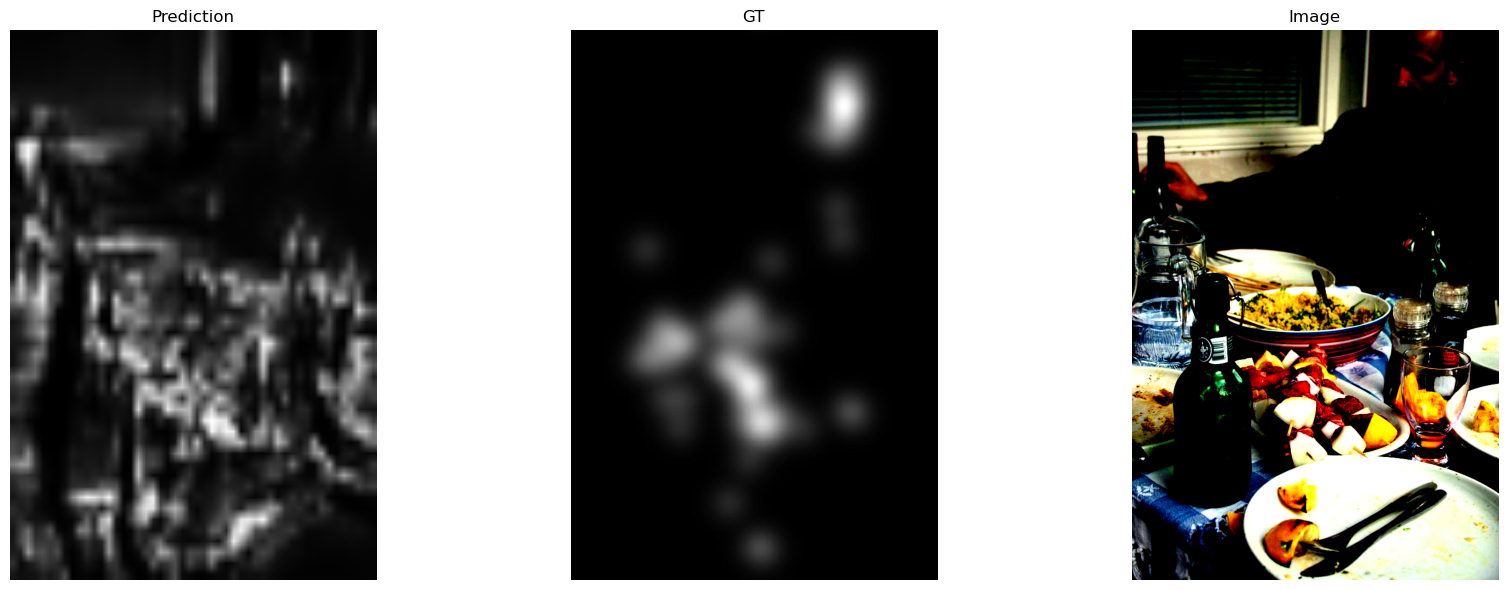

In [230]:
pred_sal_map, gt_sal_map, img = get_sal_maps(j, test_preds_dict, test_ground_truth_dict)

# visualise_sal_map(pred_sal_map)
# visualise_sal_map(gt_sal_map)

img = img.permute(1, 2, 0).numpy()
visualise_triple(pred_sal_map, gt_sal_map, img)